# learning `PerformanceAnalytics`

The `PerformanceAnalytics` package ([CRAN](https://cran.r-project.org/web/packages/PerformanceAnalytics/index.html)) has a collection of portfolio performance and risk analysis functions.

## Portfolio returns

This [vignette](https://cran.r-project.org/web/packages/PerformanceAnalytics/vignettes/portfolio_returns.pdf) introduces basic concepts and functions for computing portfolio returns. The logic is used to create the `Return.portfolio()` function.

By default, this function calculates the time series of portfolio returns given 1) asset returns and 2) weights.

### Prices and shares framework

In [ ]:
library(tidyverse)
library(tidyquant)
library(magrittr)

First step is to get individual stock prices. Here we set the first date to be `2012-12-31` so that we can decide how many shares of each stock to purchase at the beginning of `2013-01-02` which is the first trading date of 2013.

In [2]:
stock.prices <- c("FB", "AMZN", "NFLX", "GOOG") %>%
  tq_get(get = "stock.prices", from = "2012-12-31")

The result is a tibble.

In [3]:
class(stock.prices)

[1] "tbl_df"     "tbl"        "data.frame"

In [4]:
head(stock.prices)

symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FB,2012-12-31,26.20,26.99,26.11,26.62,60374500,26.62
FB,2013-01-02,27.44,28.18,27.42,28.00,69846400,28.00
FB,2013-01-03,27.88,28.47,27.59,27.77,63140600,27.77
FB,2013-01-04,28.01,28.93,27.83,28.76,72715400,28.76
FB,2013-01-07,28.69,29.79,28.65,29.42,83781800,29.42
FB,2013-01-08,29.51,29.60,28.86,29.06,45871300,29.06


In [5]:
stock.prices.wider <- stock.prices %>%
  select(date, symbol, adjusted) %>%
  pivot_wider(names_from = symbol, values_from = adjusted) %>%
  column_to_rownames("date") %>%
  as.xts()
head(stock.prices.wider)

              FB   AMZN     NFLX     GOOG
2012-12-31 26.62 250.87 13.22714 352.3692
2013-01-02 28.00 257.31 13.14429 360.2746
2013-01-03 27.77 258.48 13.79857 360.4838
2013-01-04 28.76 259.15 13.71143 367.6071
2013-01-07 29.42 268.46 14.17143 366.0031
2013-01-08 29.06 266.38 13.88000 365.2808

In [149]:
stock.returns <- stock.prices %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn, leading = TRUE)
head(stock.returns)

symbol,date,daily.returns
<chr>,<date>,<dbl>
FB,2012-12-31,0.000000000
FB,2013-01-02,0.051840682
FB,2013-01-03,-0.008214286
FB,2013-01-04,0.035649982
FB,2013-01-07,0.022948540
FB,2013-01-08,-0.012236608


In [150]:
stock.returns.wider <- stock.returns %>%
  pivot_wider(names_from = symbol, values_from = daily.returns) %>%
  column_to_rownames("date") %>%
  as.xts()
head(stock.returns.wider)

                     FB         AMZN         NFLX          GOOG
2012-12-31  0.000000000  0.000000000  0.000000000  0.0000000000
2013-01-02  0.051840682  0.025670679 -0.006264165  0.0224348901
2013-01-03 -0.008214286  0.004547095  0.049777143  0.0005807487
2013-01-04  0.035649982  0.002592011 -0.006315292  0.0197603623
2013-01-07  0.022948540  0.035925129  0.033548655 -0.0043632833
2013-01-08 -0.012236608 -0.007747844 -0.020564546 -0.0019735350

In [8]:
N <- ncol(stock.returns.wider)
N

[1] 4

In [9]:
stock.weights.wider <- stock.returns.wider[1, ]
coredata(stock.weights.wider) <- matrix(rep(1/N, N), nrow = 1)
stock.weights.wider

             FB AMZN NFLX GOOG
2012-12-31 0.25 0.25 0.25 0.25

In [10]:
# stock.shares.wider <- stock.weights.wider / stock.prices.wider
# stock.shares.wider

In [11]:
portfolio.value.0 <- 1

In [12]:
# stock.values.wider <- stock.shares.wider * stock.prices.wider
stock.values.wider <- portfolio.value.0 * stock.weights.wider
stock.values.wider

             FB AMZN NFLX GOOG
2012-12-31 0.25 0.25 0.25 0.25

In [13]:
for (i in seq(2, nrow(stock.returns.wider))) {
    idx <- index(stock.returns.wider[i, ])
    v <- coredata(stock.values.wider[i-1, ]) * (1 + coredata(stock.returns.wider[i, ]))
    stock.values.wider <- rbind(stock.values.wider, xts(v, idx))
}
head(stock.values.wider)

                  FB      AMZN      NFLX      GOOG
2012-12-31 0.2500000 0.2500000 0.2500000 0.2500000
2013-01-02 0.2629602 0.2564177 0.2484340 0.2556087
2013-01-03 0.2608001 0.2575836 0.2608003 0.2557572
2013-01-04 0.2700977 0.2582513 0.2591533 0.2608110
2013-01-07 0.2762960 0.2675290 0.2678475 0.2596730
2013-01-08 0.2729151 0.2654562 0.2623393 0.2591606

In [14]:
portfolio.values <- xts(
    matrix(rowSums(stock.values.wider), dimnames = list(NULL, "portfolio")),
    index(stock.values.wider)
)
head(portfolio.values)

           portfolio
2012-12-31  1.000000
2013-01-02  1.023421
2013-01-03  1.034941
2013-01-04  1.048313
2013-01-07  1.071346
2013-01-08  1.059871

In [15]:
for (i in seq(2, nrow(stock.values.wider))) {
    v <- stock.values.wider[i, ]
    stock.weights.wider <- rbind(stock.weights.wider, xts(v/sum(v), index(v)))
}
head(stock.weights.wider)

                  FB      AMZN      NFLX      GOOG
2012-12-31 0.2500000 0.2500000 0.2500000 0.2500000
2013-01-02 0.2569424 0.2505497 0.2427487 0.2497592
2013-01-03 0.2519951 0.2488872 0.2519953 0.2471224
2013-01-04 0.2576498 0.2463494 0.2472098 0.2487911
2013-01-07 0.2578963 0.2497131 0.2500104 0.2423803
2013-01-08 0.2574983 0.2504608 0.2475200 0.2445208

In [16]:
portfolio.returns <- dailyReturn(portfolio.values, leading = FALSE)
head(portfolio.returns)

           daily.returns
2012-12-31            NA
2013-01-02    0.02342052
2013-01-03    0.01125706
2013-01-04    0.01292054
2013-01-07    0.02197083
2013-01-08   -0.01071021

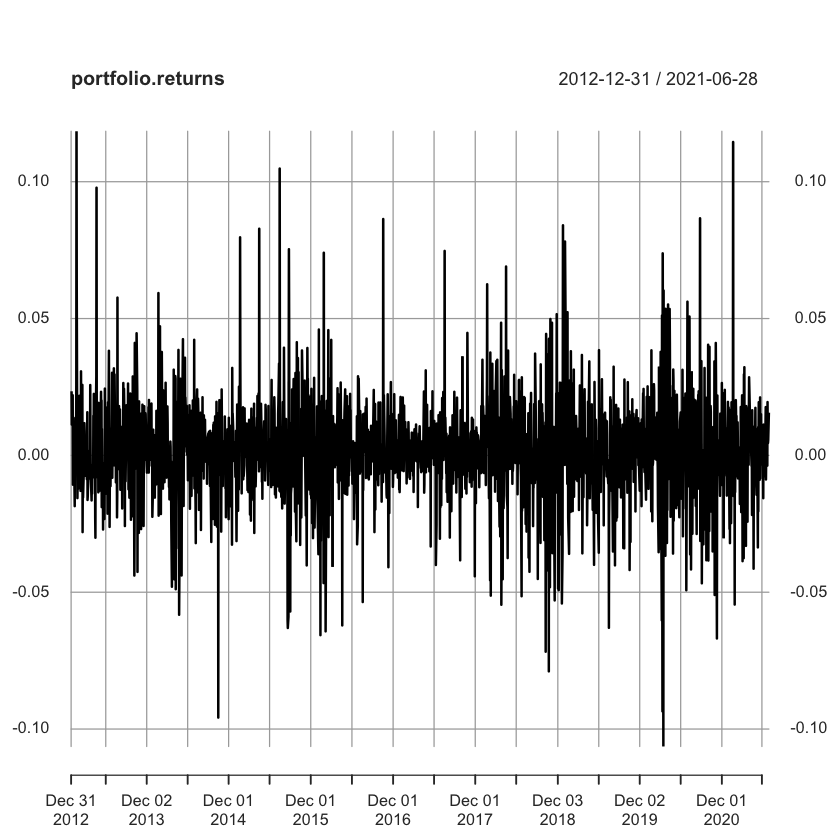

In [17]:
plot(portfolio.returns)

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


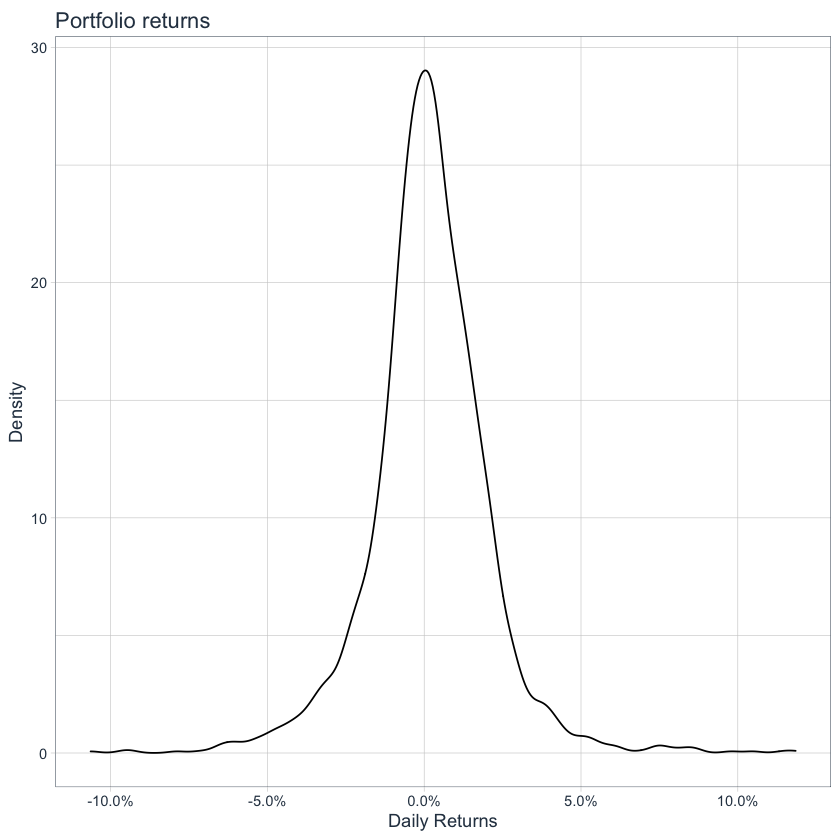

In [18]:
portfolio.returns %>%
  ggplot(aes(x = daily.returns)) +
    geom_density(alpha = 0.5) +
    scale_x_continuous(label = scales::percent) +
    labs(title = "Portfolio returns",
         x = "Daily Returns", y = "Density") +
    theme_tq()

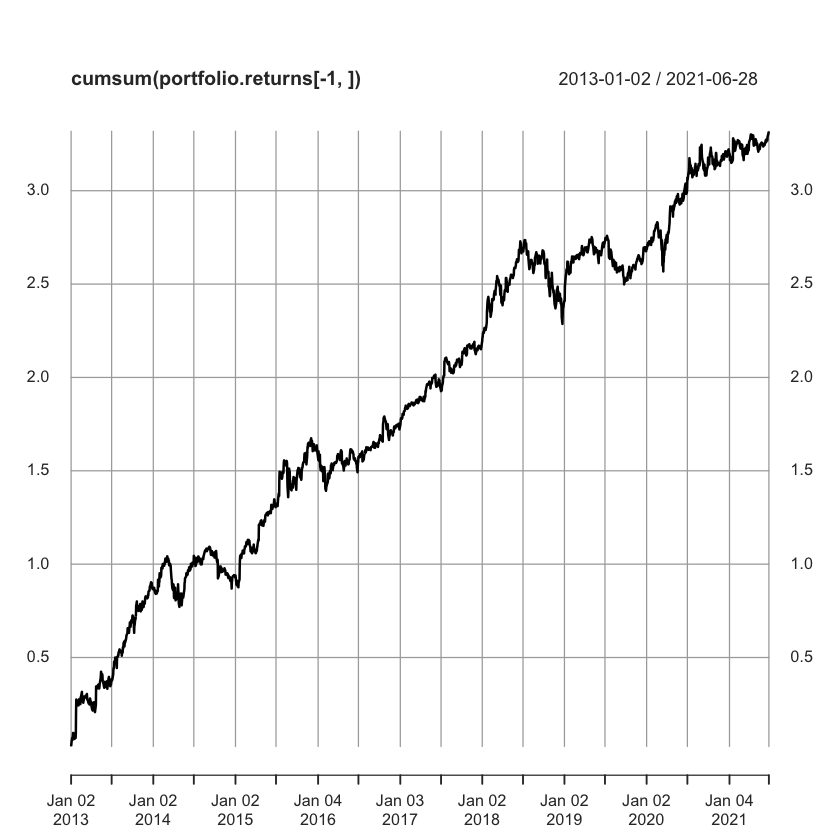

In [19]:
plot(cumsum(portfolio.returns[-1, ]))

### A functional approach

In [172]:
CumeReturn <- function(x) {
    if (NCOL(x) == 1) {
        x[] <- cumprod(coredata(x) + 1) - 1
    }
    else x[] <- apply(coredata(x), 2, function(y) cumprod(y + 1) - 1)
    x
}
                      
Return.buyandhold <- function(returns) {
    # num of assets
    N <- ncol(returns)
    # stock cumulative returns
    cume.returns <- CumeReturn(returns)
    # equal weights among assets
    weights <- xts(
        matrix(rep(1/N, N), nrow = 1, dimnames = list(NULL, colnames(returns))),
        index(returns[1, ])
    )
    # contributions
    contributions <- xts(
        matrix(rep(0.0, N), nrow = 1, dimnames = list(NULL, colnames(returns))),
        index(returns[1, ])
    )
    cume.contributions <- xts(
        matrix(rep(0.0, N), nrow = 1, dimnames = list(NULL, colnames(returns))),
        index(returns[1, ])
    )
    # initial portfolio value, can be any positive number
    p.value.0 <- 1
    # stock values evolution
    values <- p.value.0 * weights
    for (i in seq(2, nrow(returns))) {
        idx <- index(returns[i, ])
        .v <- coredata(values[i-1, ]) * (1 + coredata(returns[i, ]))
        values <- rbind(values, xts(.v, idx))
        .w <- .v/sum(.v)
        weights <- rbind(weights, xts(.w, idx))
        .c <- coredata(weights[i-1, ]) * coredata(returns[i, ])
        .cc <- coredata(weights[1, ]) * coredata(cume.returns[i, ])
        contributions <- rbind(contributions, xts(.c, idx))
        cume.contributions <- rbind(cume.contributions, xts(.cc, idx))
    }
    # portfolio values
    p.values <- xts(
        matrix(rowSums(values), dimnames = list(NULL, "portfolio")),
        index(values)
    )
    # portfolio returns
    p.returns <- dailyReturn(p.values)
    p.cume.returns <- CumeReturn(p.returns)
    res <- list(
        returns = p.returns,
        cume.returns = p.cume.returns,
        values = p.values,
        stock.values = values,
        stock.returns = returns,
        stock.cume.returns = cume.returns,
        stock.weights = weights,
        stock.contributions = contributions,
        stock.cume.contributions = cume.contributions
    )
    return(res)
}

In [173]:
x <- Return.buyandhold(stock.returns.wider)

In [165]:
head(x$returns)

           daily.returns
2012-12-31    0.00000000
2013-01-02    0.02342052
2013-01-03    0.01125706
2013-01-04    0.01292054
2013-01-07    0.02197083
2013-01-08   -0.01071021

In [166]:
head(x$cume.returns)

           daily.returns
2012-12-31    0.00000000
2013-01-02    0.02342052
2013-01-03    0.03494122
2013-01-04    0.04831323
2013-01-07    0.07134554
2013-01-08    0.05987120

In [154]:
head(x$values)

           portfolio
2012-12-31  1.000000
2013-01-02  1.023421
2013-01-03  1.034941
2013-01-04  1.048313
2013-01-07  1.071346
2013-01-08  1.059871

In [155]:
head(x$stock.weights)

                  FB      AMZN      NFLX      GOOG
2012-12-31 0.2500000 0.2500000 0.2500000 0.2500000
2013-01-02 0.2569424 0.2505497 0.2427487 0.2497592
2013-01-03 0.2519951 0.2488872 0.2519953 0.2471224
2013-01-04 0.2576498 0.2463494 0.2472098 0.2487911
2013-01-07 0.2578963 0.2497131 0.2500104 0.2423803
2013-01-08 0.2574983 0.2504608 0.2475200 0.2445208

In [156]:
head(x$stock.returns)

                     FB         AMZN         NFLX          GOOG
2012-12-31  0.000000000  0.000000000  0.000000000  0.0000000000
2013-01-02  0.051840682  0.025670679 -0.006264165  0.0224348901
2013-01-03 -0.008214286  0.004547095  0.049777143  0.0005807487
2013-01-04  0.035649982  0.002592011 -0.006315292  0.0197603623
2013-01-07  0.022948540  0.035925129  0.033548655 -0.0043632833
2013-01-08 -0.012236608 -0.007747844 -0.020564546 -0.0019735350

In [161]:
head(x$stock.contributions)

                     FB          AMZN         NFLX          GOOG
2012-12-31  0.000000000  0.0000000000  0.000000000  0.0000000000
2013-01-02  0.012960170  0.0064176696 -0.001566041  0.0056087225
2013-01-03 -0.002110599  0.0011392731  0.012083335  0.0001450473
2013-01-04  0.008983622  0.0006451183 -0.001591424  0.0048832283
2013-01-07  0.005912686  0.0088501323  0.008293555 -0.0010855461
2013-01-08 -0.003155775 -0.0019347379 -0.005141350 -0.0004783460

In [174]:
head(x$stock.cume.contributions)

                   FB        AMZN         NFLX        GOOG
2012-12-31 0.00000000 0.000000000  0.000000000 0.000000000
2013-01-02 0.01296017 0.006417670 -0.001566041 0.005608723
2013-01-03 0.01080014 0.007583625  0.010800291 0.005757167
2013-01-04 0.02009766 0.008251285  0.009153262 0.010811021
2013-01-07 0.02629601 0.017528995  0.017847505 0.009673029
2013-01-08 0.02291508 0.015456223  0.012339343 0.009160555

### `Return.portfolio()` approach

In [26]:
library(PerformanceAnalytics)

In [27]:
portfolio.returns.2 <- Return.portfolio(stock.returns.wider[-1. ], verbose = TRUE)

In [28]:
names(portfolio.returns.2)

[1] "returns"      "contribution" "BOP.Weight"   "EOP.Weight"   "BOP.Value"   
[6] "EOP.Value"

In [29]:
head(portfolio.returns.2$returns)

           portfolio.returns
2013-01-02        0.02342052
2013-01-03        0.01125706
2013-01-04        0.01292054
2013-01-07        0.02197083
2013-01-08       -0.01071021
2013-01-09        0.01195182

In [30]:
head(portfolio.returns.2$BOP.Weight)

                  FB      AMZN      NFLX      GOOG
2013-01-02 0.2500000 0.2500000 0.2500000 0.2500000
2013-01-03 0.2569424 0.2505497 0.2427487 0.2497592
2013-01-04 0.2519951 0.2488872 0.2519953 0.2471224
2013-01-07 0.2576498 0.2463494 0.2472098 0.2487911
2013-01-08 0.2578963 0.2497131 0.2500104 0.2423803
2013-01-09 0.2574983 0.2504608 0.2475200 0.2445208

In [31]:
head(portfolio.returns.2$BOP.Value)

                  FB      AMZN      NFLX      GOOG
2013-01-02 0.2500000 0.2500000 0.2500000 0.2500000
2013-01-03 0.2629602 0.2564177 0.2484340 0.2556087
2013-01-04 0.2608001 0.2575836 0.2608003 0.2557572
2013-01-07 0.2700977 0.2582513 0.2591533 0.2608110
2013-01-08 0.2762960 0.2675290 0.2678475 0.2596730
2013-01-09 0.2729151 0.2654562 0.2623393 0.2591606

In [32]:
head(portfolio.returns.2$contribution)

                     FB          AMZN         NFLX          GOOG
2013-01-02  0.012960170  6.417670e-03 -0.001566041  0.0056087225
2013-01-03 -0.002110599  1.139273e-03  0.012083335  0.0001450473
2013-01-04  0.008983622  6.451183e-04 -0.001591424  0.0048832283
2013-01-07  0.005912686  8.850132e-03  0.008293555 -0.0010855461
2013-01-08 -0.003155775 -1.934738e-03 -0.005141350 -0.0004783460
2013-01-09  0.013557218 -2.820623e-05 -0.003184431  0.0016072420

## A different portfolio

### A buy-and-hold strategy

In [38]:
p1 <- c("BABA", "FB", "PLTR", "SNOW") %>%
  tq_get(get = "stock.prices", from = "2020-09-30")

In [175]:
p1.returns <- p1 %>%
  group_by(symbol) %>%
  tq_mutate(
      select = adjusted,
      mutate_fun = dailyReturn,
      leading = TRUE
  ) %>%
  select(symbol, date, daily.returns) %>%
  pivot_wider(names_from = symbol, values_from = daily.returns) %>%
  column_to_rownames("date") %>%
  as.xts()
head(p1.returns)

                    BABA           FB         PLTR         SNOW
2020-09-30  0.0000000000  0.000000000  0.000000000  0.000000000
2020-10-01 -0.0133683341  0.018060371 -0.004210526 -0.030039813
2020-10-02 -0.0064815552 -0.025090961 -0.027484144 -0.067197899
2020-10-05  0.0003469341  0.018119535 -0.018478261  0.056803142
2020-10-06  0.0142922474 -0.022633630  0.096345515  0.021250025
2020-10-07  0.0140565163 -0.002087717  0.010101010  0.003671946

In [176]:
x <- p1.returns %>%
  Return.buyandhold()

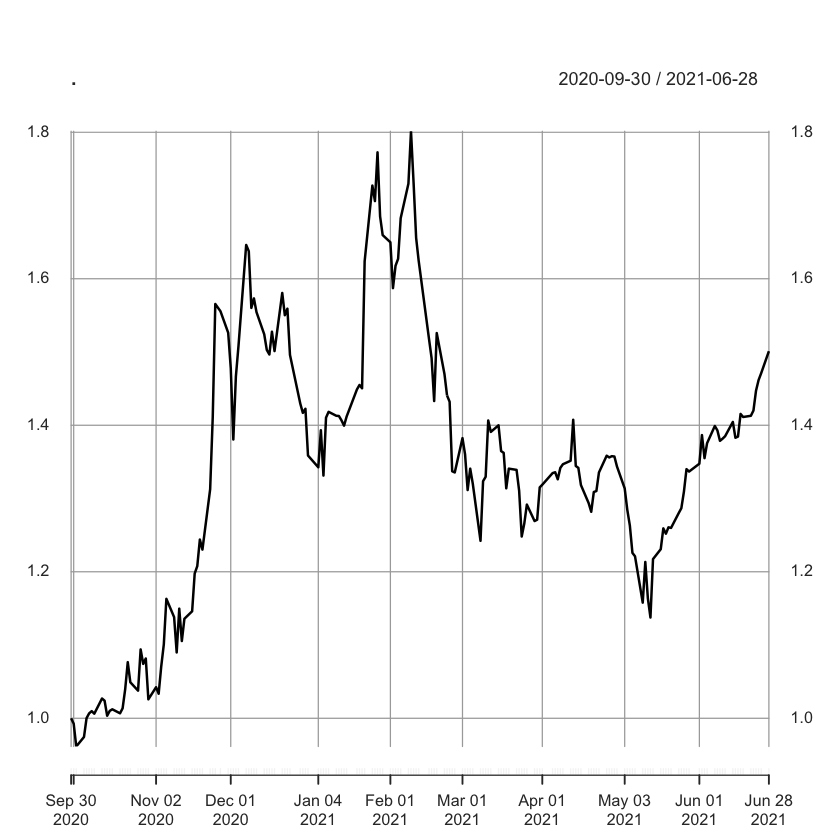

In [177]:
x$values %>% plot()

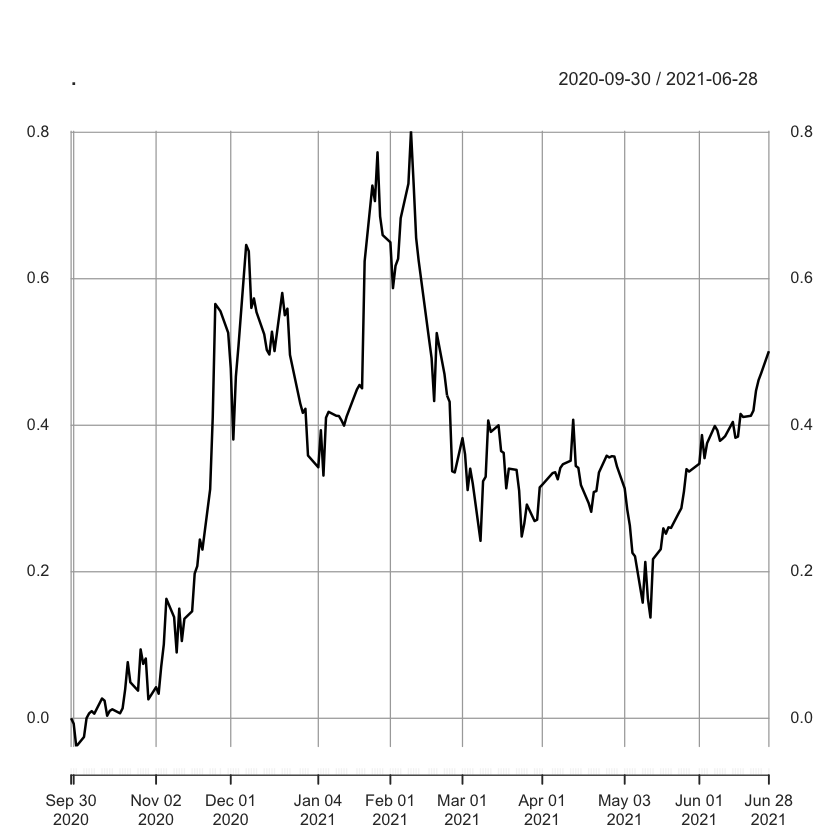

In [178]:
x$cume.returns %>% plot()

In [179]:
head(x$returns)

           daily.returns
2020-09-30   0.000000000
2020-10-01  -0.007389576
2020-10-02  -0.031353370
2020-10-05   0.013474852
2020-10-06   0.026435841
2020-10-07   0.006506304

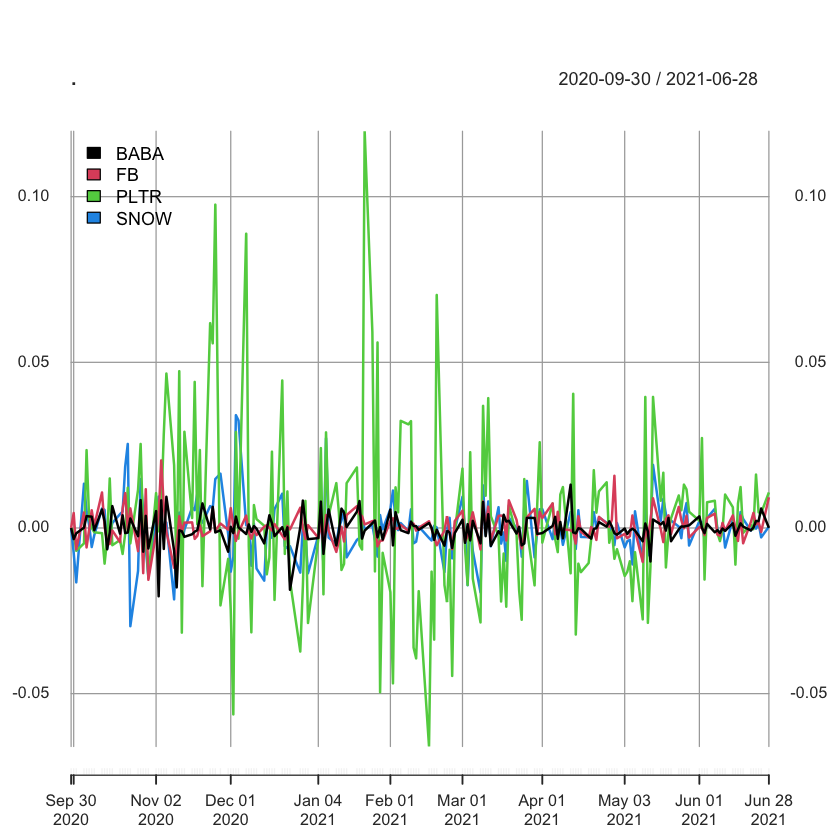

In [180]:
x$stock.contributions %>%
  na.omit() %>%
  plot(legend.loc = "topleft")

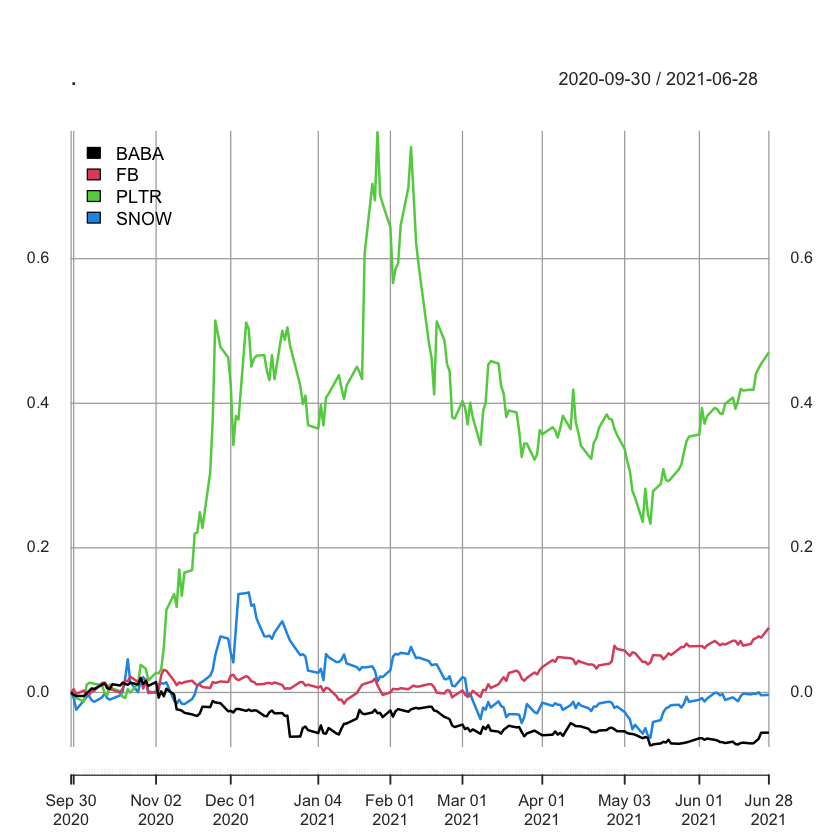

In [182]:
x$stock.cume.contributions %>%
  plot(legend.loc = "topleft")

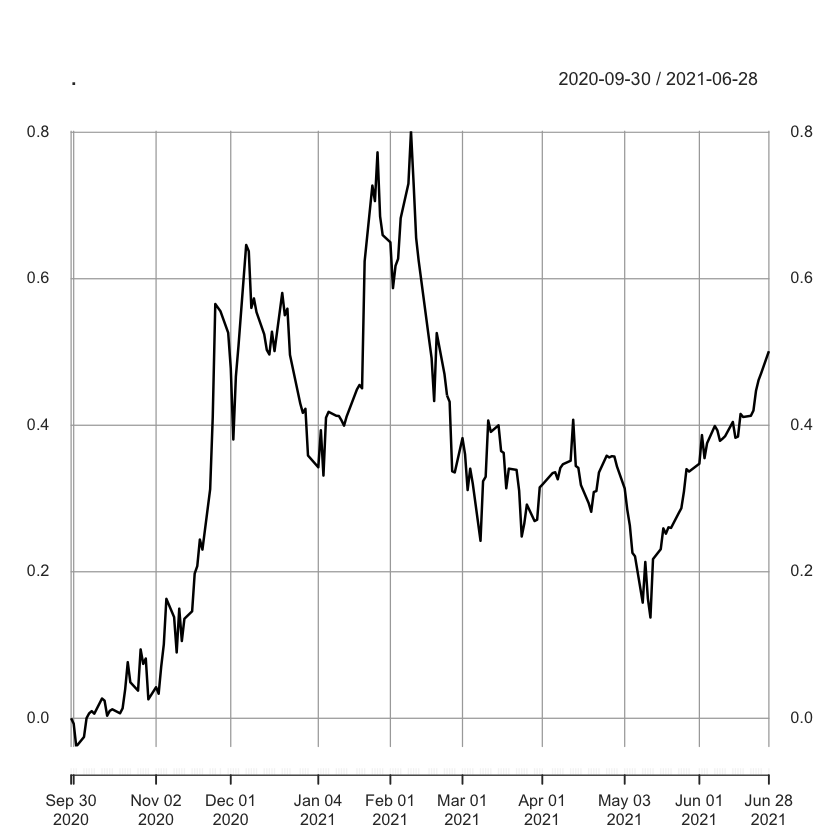

In [191]:
x$stock.cume.contributions %>% apply(1, sum) %>% as.xts() %>% plot()

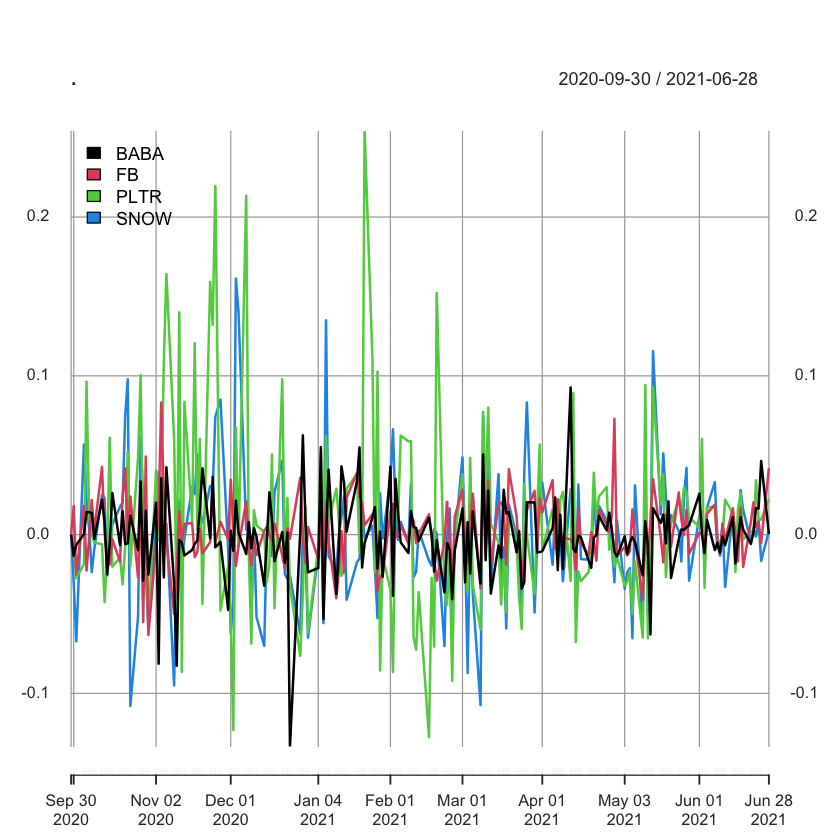

In [193]:
x$stock.returns %>% plot(legend.loc = "topleft")

In [202]:
x$stock.returns.longer <- x$stock.returns %>%
  as_tibble(rownames = "date") %>%
  mutate(date = as.Date(date)) %>%
  pivot_longer(BABA:SNOW, names_to = "symbol", values_to = "daily.returns")

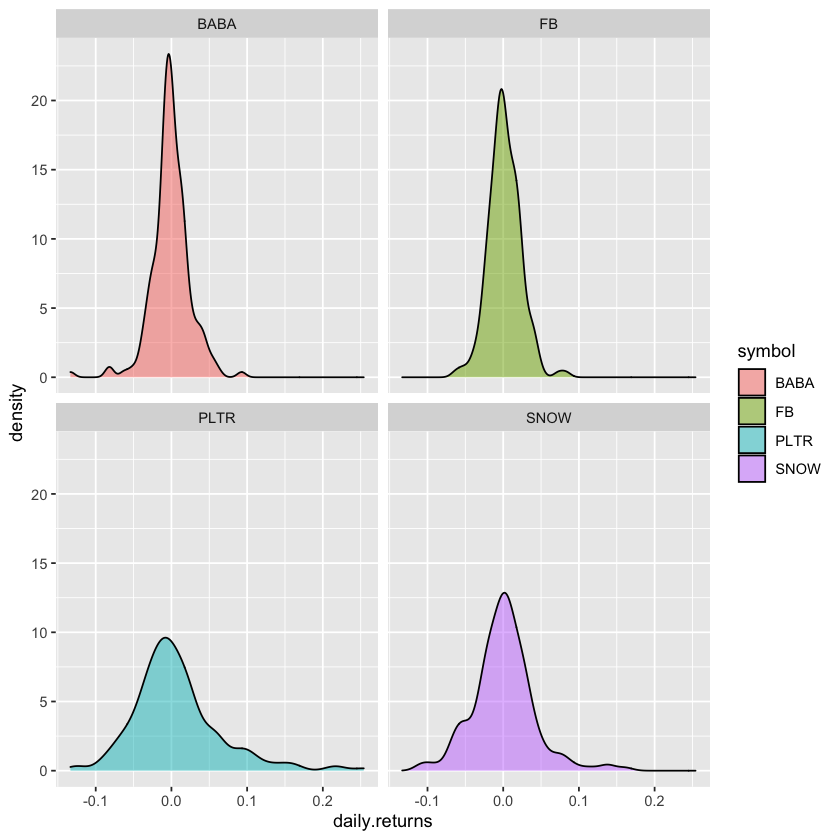

In [203]:
x$stock.returns.longer %>%
  ggplot(aes(x = daily.returns)) +
    geom_density(aes(fill = symbol), alpha = 0.5) +
    facet_wrap(~symbol, ncol = 2)

In [205]:
x$stock.returns.longer %>%
  group_by(symbol) %>%
  summarize(volatility = sd(daily.returns))

symbol,volatility
<chr>,<dbl>
BABA,0.02535561
FB,0.02099788
PLTR,0.05803398
SNOW,0.04048116
